# Results of simulation of different fairness policies

These experiments use accumulated deficits to try to ensure that applications always receive their computed allocation of GPU time, even in the event of new jobs coming in and old jobs finishing, by keeping track of the difference between the GPU time the application should have received, and the GPU time the application actually received. Allocation of jobs to GPUs is performed in a round-based fashion, with GPUs instructed to run jobs for a fixed interval of time on all GPUs.

# Import statements

In [1]:
from matplotlib import pyplot as plt
import matplotlib; matplotlib.font_manager._rebuild()
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
sns.set_style('ticks')
font = {
    'font.family':'Roboto',
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=2, rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
# Other imports.
import os
import re

# Get logfile paths

In [3]:
def get_logfile_paths_helper(directory_name):
    logfile_paths = []
    for root, _, file_names in os.walk(directory_name):
        if len(file_names) > 0:
            logfile_paths.extend(
                [os.path.join(root, file_name)
                 for file_name in file_names])
    return logfile_paths

def get_logfile_paths(directory_name):
    logfile_paths = []
    for logfile_path in get_logfile_paths_helper(directory_name):
        m = re.match(
            r'.*v100=(\d+)\.p100=(\d+)\.k80=(\d+)/(.*)/seed=(\d+)/'
             'lambda=(\d+\.\d+)\.log', logfile_path)
        if m is None: continue
        v100s = int(m.group(1))
        p100s = int(m.group(2))
        k80s = int(m.group(3))
        policy = m.group(4)
        seed = int(m.group(5))
        l = float(m.group(6))
        logfile_paths.append((v100s, p100s, k80s, policy, seed,
                              l, logfile_path))
    return logfile_paths

In [4]:
labels = {"allox": "AlloX",
          "gandiva": "LAS+SS (Gandiva)",
          "fifo": "FIFO",
          "fifo_perf": "FIFO+perf",
          "fifo_packed": "FIFO+perf+SS",
          "finish_time_fairness": "FTF",
          "finish_time_fairness_perf": "FTF+perf",
          "max_min_fairness": "LAS",
          "max_min_fairness_perf": "LAS+perf",
          "max_min_fairness_packed": "LAS+perf+SS"}

# Plotting functions

In [5]:
def prune(logfile_paths, v100s, p100s, k80s, policy, seed=None):
    if seed is None:
        return sorted([(x[5], x[6], x[4]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy])
    else:
        return sorted([(x[5], x[6]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy and
                       x[4] == seed])

In [6]:
def plot_metric_vs_inverse_lambda(v100s, p100s, k80s,
                                  policies, metric_fn,
                                  metric_label,
                                  xmax=None,
                                  ymax=None,
                                  output_filename=None,
                                  extrapolate=False):
    plt.figure(figsize=(6, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

    data = {"input_job_rate": [], "metric": [], "seed": [],
            "policy": []}
    print(policies)
    for policy in policies:
        relevant_mechanism_logfile_paths = list(reversed(prune(
            mechanism_logfile_paths, v100s, p100s, k80s, policy)))
        relevant_ideal_logfile_paths = list(reversed(prune(
            ideal_logfile_paths, v100s, p100s, k80s, policy)))

        for relevant_logfile_paths, label in zip(
            [relevant_mechanism_logfile_paths, relevant_ideal_logfile_paths],
            [labels[policy], labels[policy] + " (id.)"]):
            lambdas = [x[0] for x in relevant_logfile_paths]
            input_job_rates = [3600.0 / x for x in lambdas]
            metrics = [metric_fn(x[1]) for x in relevant_logfile_paths]
            seeds = [x[2] for x in relevant_logfile_paths]

            policies = [label for i in range(len(metrics))]
            data["input_job_rate"] += input_job_rates
            data["metric"] += metrics
            data["seed"] += seeds
            data["policy"] += policies
            if len(input_job_rates) > 0 and extrapolate:
                data["input_job_rate"] += [max(input_job_rates) + 0.4]
                data["metric"] += [105.0]
                data["seed"] += [0]
                data["policy"] += [label]

    sns.lineplot(x='input_job_rate', y='metric', style='policy',
                 hue='policy',
                 data=data, ci='sd',
                 markers=True)

    ax.set_xlabel("Input job rate (jobs/hr)")
    ax.set_ylabel(metric_label)
    ax.set_xlim([0, xmax])
    ax.set_ylim([0, ymax])
    sns.despine()
    
    leg = plt.legend(loc='upper left', frameon=False)
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    bb.y0 += 0.1
    bb.y1 += 0.1
    leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    
    plt.show()

In [7]:
import random
import sys; sys.path.append("../../..")
from job_table import JobTable

def get_job_durations(seed, generate_multigpu_jobs):
    job_generator = random.Random()
    job_generator.seed(seed+2)
    
    job_durations = []
    for i in range(5000):
        r = job_generator.uniform(0, 1)
        scale_factor = 1
        if 0.7 <= r <= 0.8:
            scale_factor = 2
        elif 0.8 <= r <= 0.95:
            scale_factor = 4
        elif 0.95 <= r:
            scale_factor = 8
        if not generate_multigpu_jobs:
            scale_factor = 1
        if job_generator.random() >= 0.8:
            job_duration = 60 * (10 ** job_generator.uniform(3, 4))
        else:
            job_duration = 60 * (10 ** job_generator.uniform(1.5, 3))

        while True:
            job_template = job_generator.choice(JobTable)
            if (scale_factor == 1 or
                (scale_factor > 1 and job_template.distributed)):
                break
                
        job_durations.append((job_duration, job_template))
    return job_durations

In [8]:
def get_jcts(logfile_path, seed, min_job_id=None, max_job_id=None):
    job_completion_times = []
    job_durations = get_job_durations(seed, generate_multigpu_jobs=False)
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        for line in lines[-10000:]:
            m = re.match(r'Job (\d+): (\d+\.\d+)', line)
            if m is not None:
                job_id = int(m.group(1))
                job_completion_time = float(m.group(2))
                if min_job_id is None or min_job_id <= job_id:
                    if max_job_id is None or job_id <= max_job_id:
                        job_duration, job_template = job_durations[job_id]
                        job_completion_times.append(
                            (job_completion_time, job_duration))
    return [(x[0] / 3600.0, x[1] / 3600.0) for x in job_completion_times]

In [9]:
def plot_jct_cdf(v100s, p100s, k80s,
                 max_input_job_rate,
                 policies,
                 min_job_id, max_job_id,
                 finish_time_fairness=False,
                 output_directory=None):
    
    lambdas = list(set([x[5] for x in mechanism_logfile_paths]))
    lambdas.sort(reverse=True)
    print(policies)

    for l in lambdas:
        handles_in_legend = []
        labels_in_legend = []
        
        input_job_rate = 3600.0 / l
        if input_job_rate > max_input_job_rate:
            continue
        print("Input job rate: %.2f" % input_job_rate)
        
        plt.figure(figsize=(8, 3))
        axes = [
            plt.subplot2grid((1, 3), (0, 0), rowspan=1),
            plt.subplot2grid((1, 3), (0, 1), rowspan=1),
            plt.subplot2grid((1, 3), (0, 2), rowspan=1),
        ]

        for logfile_paths, label_modifier in zip(
            [mechanism_logfile_paths, ideal_logfile_paths],
            ["", " (id.)"]):
            if finish_time_fairness:
                relevant_logfile_paths = list(reversed(prune(
                    logfile_paths, v100s, p100s, k80s, "isolated", seed=0)))
                relevant_logfile_paths = [x for x in relevant_logfile_paths
                                          if x[0] == l]
                if len(relevant_logfile_paths) != 1:
                    continue
                isolated_jcts = get_jcts(relevant_logfile_paths[0][1],
                                         seed=0,
                                         min_job_id=min_job_id,
                                         max_job_id=max_job_id)
                isolated_jcts.sort(key=lambda x: x[1])
            for i, policy in enumerate(policies):
                relevant_logfile_paths = list(reversed(prune(
                    logfile_paths, v100s, p100s, k80s, policy, seed=0)))
                relevant_logfile_paths = [x for x in relevant_logfile_paths
                                          if x[0] == l]
                if len(relevant_logfile_paths) != 1:
                    continue
                jcts = get_jcts(relevant_logfile_paths[0][1],
                                seed=0,
                                min_job_id=min_job_id,
                                max_job_id=max_job_id)
                jcts.sort(key=lambda x: x[1])
                if finish_time_fairness:
                    jcts = [x[0] / y[0] for (x, y) in zip(jcts, isolated_jcts)]
                else:
                    jcts = [x[0] for x in jcts]
                    
                print("%s: %.2f" % (policy, np.mean(jcts)))
                partition_point = len(jcts) // 3
                jcts = np.split(np.array(jcts), [partition_point, 2*partition_point])
                if "id" in label_modifier:
                    marker = 'o'
                else:
                    marker = 'X'
                for j, (ax, jcts_segment) in enumerate(zip(axes, jcts)):
                    jcts_segment.sort()
                    percentiles = [(i+1) / len(jcts_segment)
                                   for i in range(len(jcts_segment))]

                    handle = ax.plot(jcts_segment, percentiles,
                                     color=current_palette[i],
                                     marker=marker,
                                     markevery=100)

                    if j == 0:
                        handles_in_legend.append(handle[0])
                        labels_in_legend.append(labels[policy] + label_modifier)

        for i, ax in enumerate(axes):
            if finish_time_fairness:
                ax.set_xlabel("FTF")
                ax.set_xlim([0, 4])
                ax.set_xticks([0, 1, 2, 3, 4])
            else:
                ax.set_xlabel("JCT (hrs)")
                ax.set_xscale('log', basex=2)
                ax.set_xlim([1, 1000])
                ax.set_xticks([1, 4, 16, 64, 256, 1024])
            if i == 0:
                ax.set_ylabel("Fraction of jobs")
            ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            if i > 0:
                ax.set_yticklabels(["", "", "", "", "", ""])
            ax.set_ylim([0, 1.0])
        sns.despine()
    
        leg = plt.figlegend(handles=handles_in_legend, labels=labels_in_legend,
                            ncol=2, frameon=False, loc='upper center')
        bb = leg.get_bbox_to_anchor().inverse_transformed(axes[1].transAxes)
        bb.y0 += 0.25
        bb.y1 += 0.25
        leg.set_bbox_to_anchor(bb, transform=axes[1].transAxes)
        
        if output_directory is not None:
            output_filename = os.path.join(output_directory,
                                           "input_job_rate=%d.pdf" % (input_job_rate * 10))
            with PdfPages(output_filename) as pdf:
                pdf.savefig(bbox_inches='tight')
        
        plt.show()

# Plot average JCT versus input job rate

In [10]:
def average_jct_fn(logfile_path, min_job_id=None, max_job_id=None):
    job_completion_times = []
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        for line in lines[-10000:]:
            m = re.match(r'Job (\d+): (\d+\.\d+)', line)
            if m is not None:
                job_id = int(m.group(1))
                job_completion_time = float(m.group(2))
                if min_job_id is None or min_job_id <= job_id:
                    if max_job_id is None or job_id <= max_job_id:
                        job_completion_times.append(
                            job_completion_time)
    if len(job_completion_times) == 0:
        return None
    return np.mean(job_completion_times) / 3600

In [11]:
mechanism_logfile_paths = sorted(get_logfile_paths(
    "/lfs/1/deepak/gpusched/scheduler/logs/single_gpu_continuous_jobs_final/"))
ideal_logfile_paths = sorted(get_logfile_paths(
    "/lfs/1/deepak/gpusched/scheduler/logs/single_gpu_continuous_jobs_ideal_final/"))

['max_min_fairness_perf', 'max_min_fairness_packed']


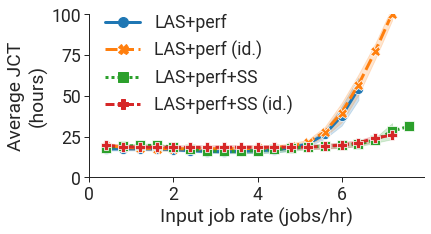

In [12]:
plot_metric_vs_inverse_lambda(
    v100s=36, p100s=36, k80s=36,
    policies=["max_min_fairness_perf",
              "max_min_fairness_packed"],
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=100.0,
    extrapolate=False,
    output_filename="continuous_jobs/single_gpu_las_ideal_v100=36_p100=36_k80=36.pdf"
)

['max_min_fairness_perf', 'max_min_fairness_packed']
Input job rate: 0.40
max_min_fairness_perf: 17.58
max_min_fairness_packed: 18.42
max_min_fairness_perf: 19.98
max_min_fairness_packed: 20.11


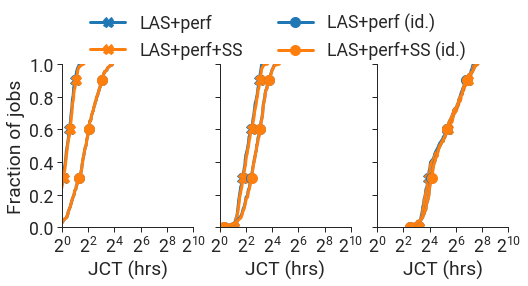

Input job rate: 0.80
max_min_fairness_perf: 17.64
max_min_fairness_packed: 19.26
max_min_fairness_perf: 18.88
max_min_fairness_packed: 19.26


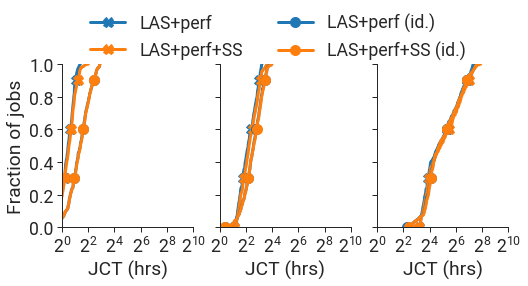

Input job rate: 1.20
max_min_fairness_perf: 17.67
max_min_fairness_packed: 19.69
max_min_fairness_perf: 18.33
max_min_fairness_packed: 18.98


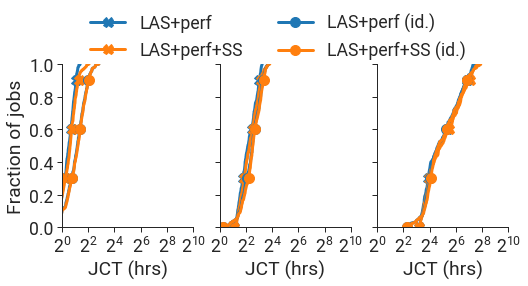

Input job rate: 1.60
max_min_fairness_perf: 17.48
max_min_fairness_packed: 19.39
max_min_fairness_perf: 18.05
max_min_fairness_packed: 18.94


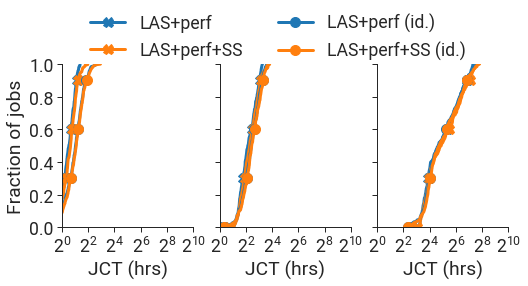

Input job rate: 2.00
max_min_fairness_perf: 16.95
max_min_fairness_packed: 18.26
max_min_fairness_perf: 17.92
max_min_fairness_packed: 18.87


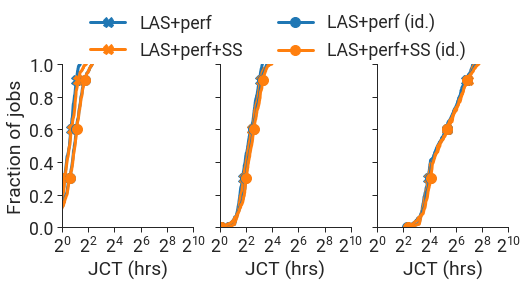

Input job rate: 2.40
max_min_fairness_perf: 16.39
max_min_fairness_packed: 16.92
max_min_fairness_perf: 17.88
max_min_fairness_packed: 18.86


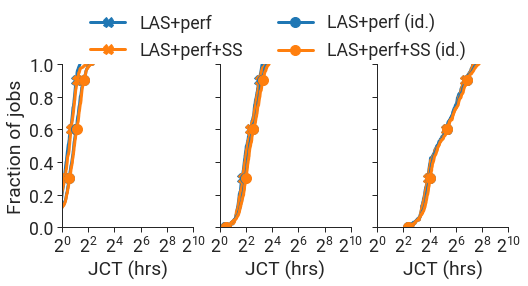

Input job rate: 2.80
max_min_fairness_perf: 16.04
max_min_fairness_packed: 16.26
max_min_fairness_perf: 17.92
max_min_fairness_packed: 18.88


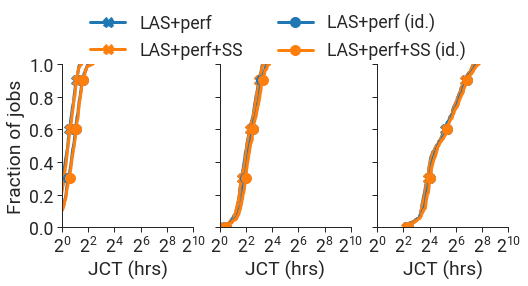

Input job rate: 3.20
max_min_fairness_perf: 16.08
max_min_fairness_packed: 16.18
max_min_fairness_perf: 17.99
max_min_fairness_packed: 18.91


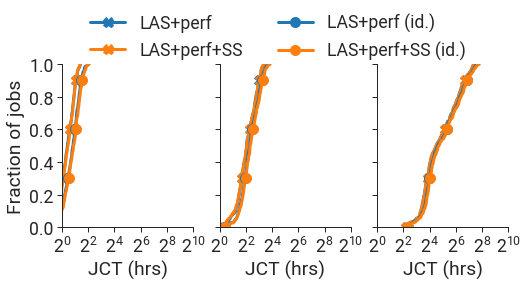

Input job rate: 3.60
max_min_fairness_perf: 16.38
max_min_fairness_packed: 16.50
max_min_fairness_perf: 18.16
max_min_fairness_packed: 18.94


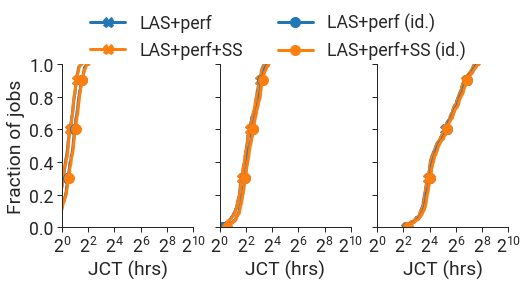

Input job rate: 4.00
max_min_fairness_perf: 16.82
max_min_fairness_packed: 16.96
max_min_fairness_perf: 18.30
max_min_fairness_packed: 18.94


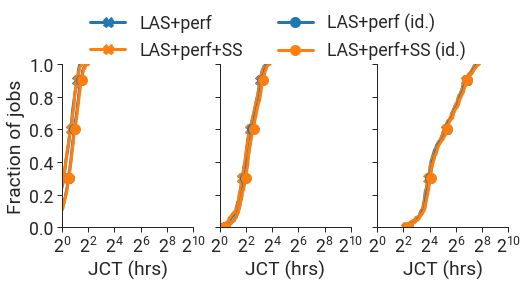

Input job rate: 4.40
max_min_fairness_perf: 17.48
max_min_fairness_packed: 17.78
max_min_fairness_perf: 18.67
max_min_fairness_packed: 18.96


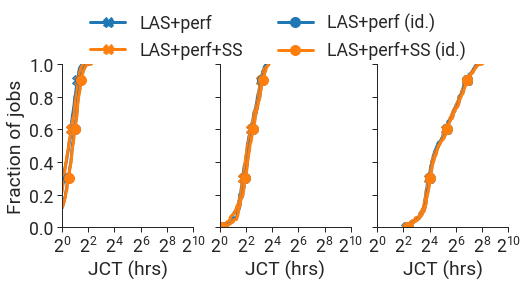

Input job rate: 4.80
max_min_fairness_perf: 18.97
max_min_fairness_packed: 18.67
max_min_fairness_perf: 19.82
max_min_fairness_packed: 18.94


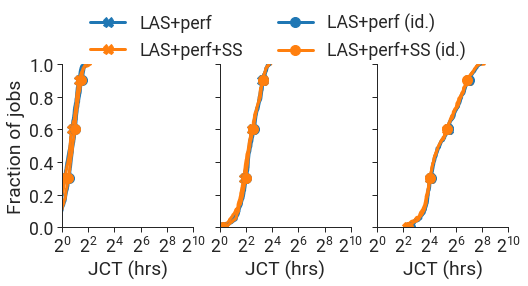

Input job rate: 5.20
max_min_fairness_perf: 22.02
max_min_fairness_packed: 19.14
max_min_fairness_perf: 22.98
max_min_fairness_packed: 19.05


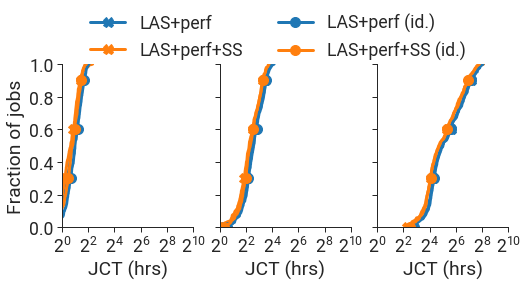

Input job rate: 5.60
max_min_fairness_perf: 28.96
max_min_fairness_packed: 19.64
max_min_fairness_perf: 30.51
max_min_fairness_packed: 19.65


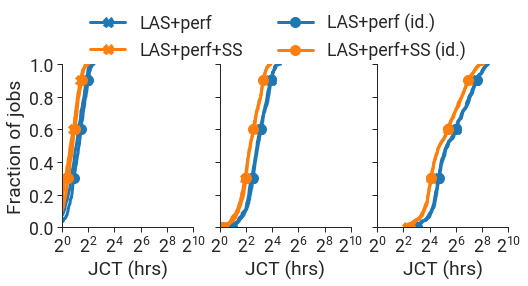

Input job rate: 6.00
max_min_fairness_perf: 41.23
max_min_fairness_packed: 20.42
max_min_fairness_perf: 43.48
max_min_fairness_packed: 20.92


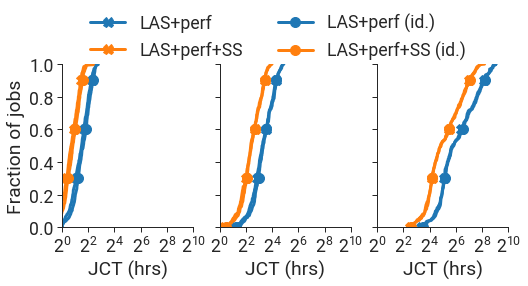

Input job rate: 6.40
max_min_fairness_perf: 59.40
max_min_fairness_packed: 21.63
max_min_fairness_perf: 61.39
max_min_fairness_packed: 22.62


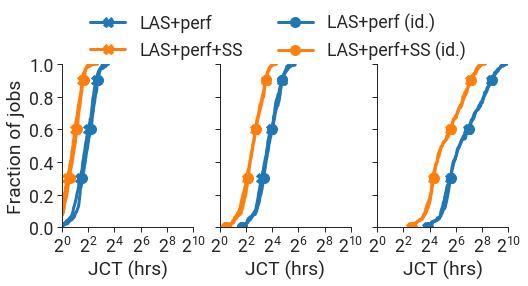

Input job rate: 6.80
max_min_fairness_packed: 24.37
max_min_fairness_perf: 81.92
max_min_fairness_packed: 26.02


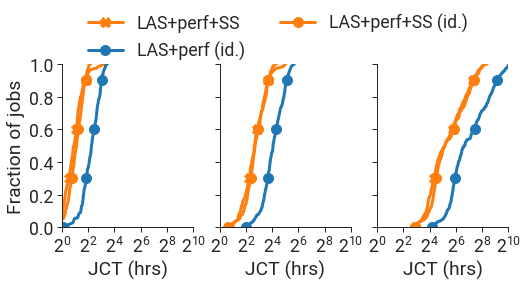

Input job rate: 7.20
max_min_fairness_packed: 31.80
max_min_fairness_perf: 105.06


/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


max_min_fairness_packed: nan


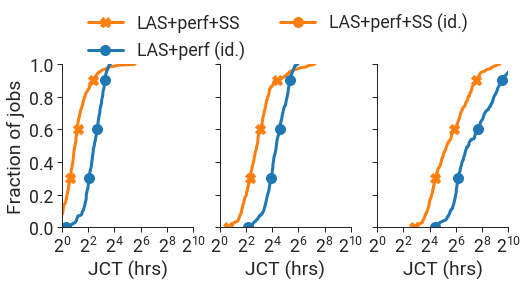

Input job rate: 7.60


/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


max_min_fairness_packed: nan
max_min_fairness_packed: nan


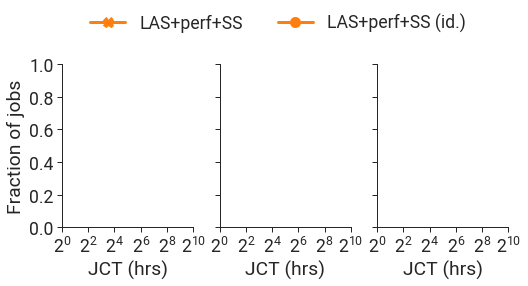

In [15]:
plot_jct_cdf(
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=8.0,
    policies=["max_min_fairness_perf",
              "max_min_fairness_packed"],
    min_job_id=4000, max_job_id=5000,
    output_directory="continuous_jobs/jct_cdf/single_gpu_las_ideal_comparison_v100=36_p100=36_k80=36/"
)

['max_min_fairness_perf', 'max_min_fairness_packed']
Input job rate: 0.40
max_min_fairness_perf: 0.84
max_min_fairness_packed: 0.89
max_min_fairness_perf: 0.85
max_min_fairness_packed: 0.85


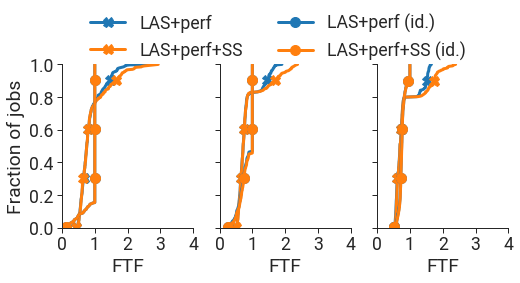

Input job rate: 0.80
max_min_fairness_perf: 0.84
max_min_fairness_packed: 0.95
max_min_fairness_perf: 0.83
max_min_fairness_packed: 0.84


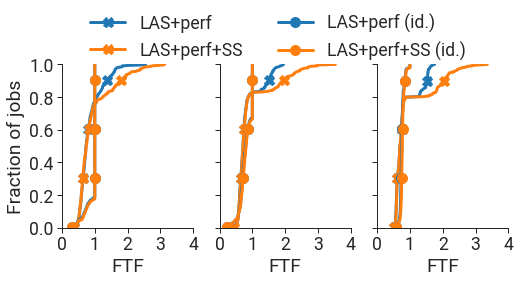

Input job rate: 1.20
max_min_fairness_perf: 0.84
max_min_fairness_packed: 0.98
max_min_fairness_perf: 0.81
max_min_fairness_packed: 0.83


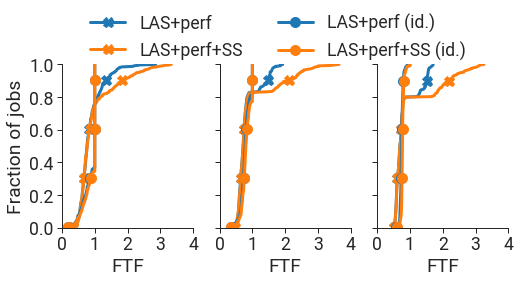

Input job rate: 1.60
max_min_fairness_perf: 0.83
max_min_fairness_packed: 0.96
max_min_fairness_perf: 0.80
max_min_fairness_packed: 0.83


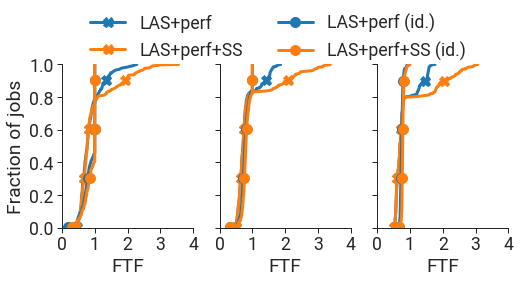

Input job rate: 2.00
max_min_fairness_perf: 0.80
max_min_fairness_packed: 0.90
max_min_fairness_perf: 0.79
max_min_fairness_packed: 0.82


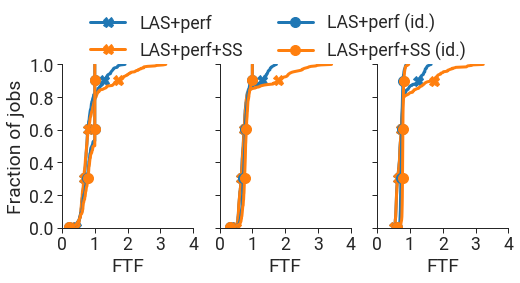

Input job rate: 2.40
max_min_fairness_perf: 0.78
max_min_fairness_packed: 0.83
max_min_fairness_perf: 0.79
max_min_fairness_packed: 0.83


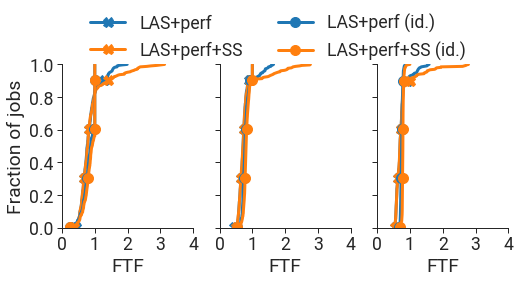

Input job rate: 2.80
max_min_fairness_perf: 0.73
max_min_fairness_packed: 0.75
max_min_fairness_perf: 0.79
max_min_fairness_packed: 0.82


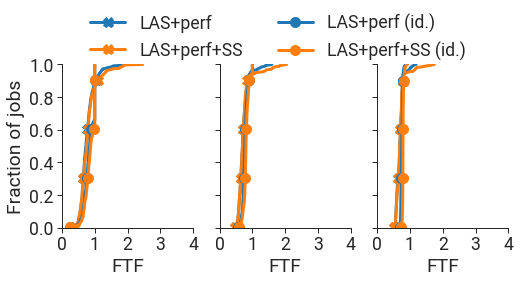

Input job rate: 3.20
max_min_fairness_perf: 0.72
max_min_fairness_packed: 0.73
max_min_fairness_perf: 0.79
max_min_fairness_packed: 0.82


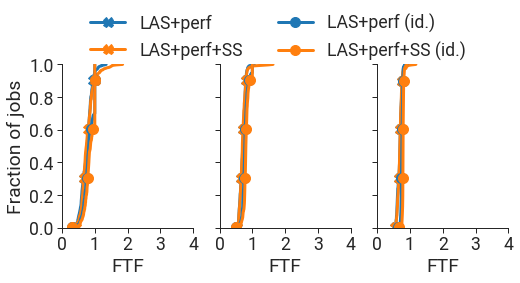

Input job rate: 3.60
max_min_fairness_perf: 0.73
max_min_fairness_packed: 0.73
max_min_fairness_perf: 0.80
max_min_fairness_packed: 0.83


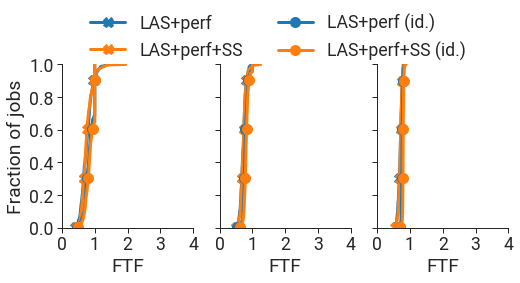

Input job rate: 4.00
max_min_fairness_perf: 0.75
max_min_fairness_packed: 0.75
max_min_fairness_perf: 0.80
max_min_fairness_packed: 0.82


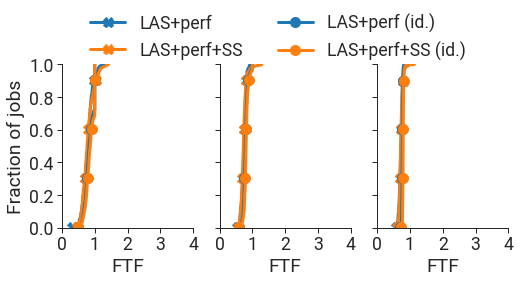

Input job rate: 4.40
max_min_fairness_perf: 0.75
max_min_fairness_packed: 0.77
max_min_fairness_perf: 0.80
max_min_fairness_packed: 0.81


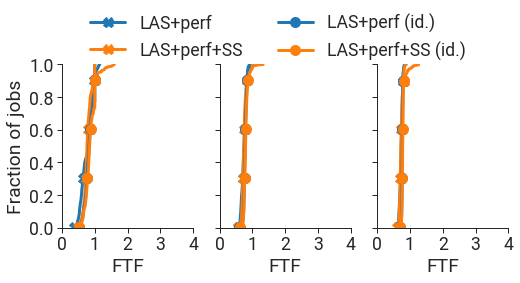

Input job rate: 4.80
max_min_fairness_perf: 0.64
max_min_fairness_packed: 0.63
max_min_fairness_perf: 0.57
max_min_fairness_packed: 0.55


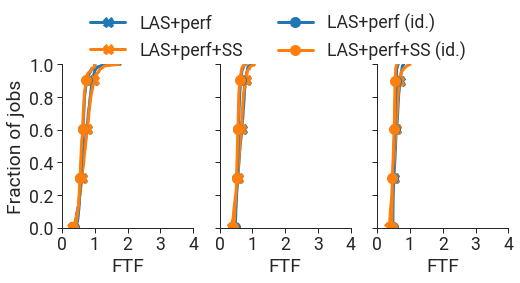

Input job rate: 5.20
max_min_fairness_perf: 0.41
max_min_fairness_packed: 0.36
max_min_fairness_perf: 0.42
max_min_fairness_packed: 0.35


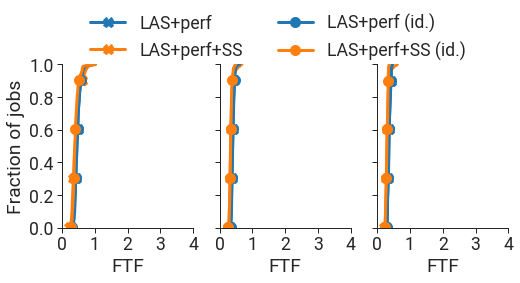

Input job rate: 5.60
max_min_fairness_perf: 0.37
max_min_fairness_packed: 0.26
max_min_fairness_perf: 0.39
max_min_fairness_packed: 0.26


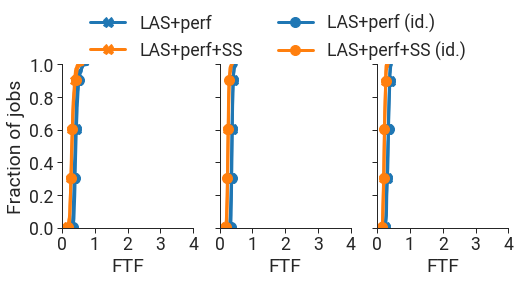

Input job rate: 6.00
max_min_fairness_perf: 0.40
max_min_fairness_packed: 0.22


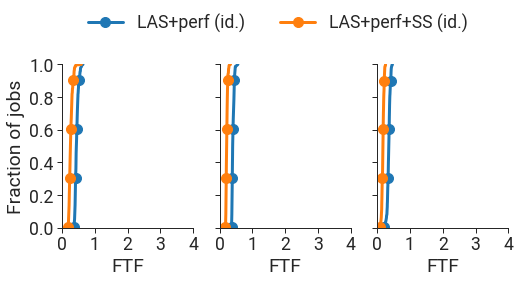

No handles with labels found to put in legend.


Input job rate: 6.40


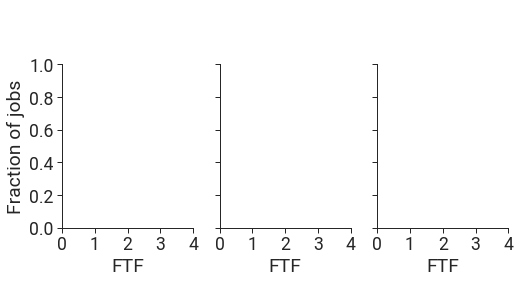

No handles with labels found to put in legend.


Input job rate: 6.80


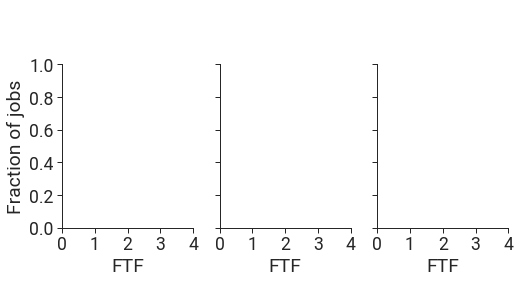

No handles with labels found to put in legend.


Input job rate: 7.20


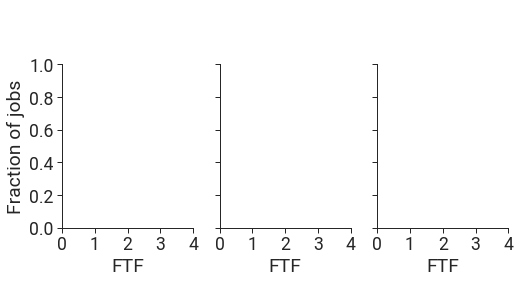

No handles with labels found to put in legend.


Input job rate: 7.60


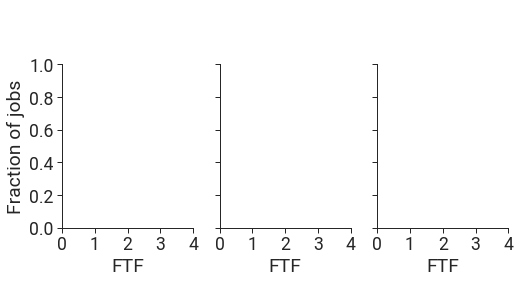

In [16]:
plot_jct_cdf(
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=8.0,
    policies=["max_min_fairness_perf",
              "max_min_fairness_packed"],
    min_job_id=4000, max_job_id=5000,
    finish_time_fairness=True,
    output_directory="continuous_jobs/ftf_cdf/single_gpu_las_ideal_comparison_v100=36_p100=36_k80=36/"
)